# COMP5318 Assignment 2: Image Classification

### Group number: 100, SID1: 490576560, SID2: 520653377 

## Setup and dependencies
All the required libraries/dependencies and the plotting environment are listed and set up here.

In [38]:
import time

import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.base import clone
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Make the notebook's output stable across runs.
# Random seed is set to 0 consistently.
np.random.seed(0)
tf.random.set_seed(0)
keras.backend.clear_session()

## 1. Data loading, preprocessing, and exploration
The documentation for the data loading function can be accessed [here](https://keras.io/api/datasets/fashion_mnist/).

### 1.1 Load data and declare variables

In [39]:
# Load the Fashion-MNIST dataset training and test sets as numpy arrays
(X_train_original, y_train_original), (X_test_original, y_test_original) = keras.datasets.fashion_mnist.load_data()
assert X_train_original.shape == (60000, 28, 28)
assert X_test_original.shape == (10000, 28, 28)
assert y_train_original.shape == (60000,)
assert y_test_original.shape == (10000,)

# An ordered list of the class names
class_names = ["T-shirt/top",
               "Trouser",
               "Pullover",
               "Dress",
               "Coat",
               "Sandal",
               "Shirt",
               "Sneaker",
               "Bag",
               "Ankle boot"
              ]

# Declare size of the image
IMAGE_SIZE = X_train_original[0].shape

### 1.2 Data processing

In [40]:
# Normalise data
X_train_full = X_train_original.reshape(X_train_original.shape[0], -1) # Flatten data from 3D to 2D
y_train_full = y_train_original.copy()
X_test = X_test_original.reshape(X_test_original.shape[0], -1) # Flatten data from 3D to 2D
y_test = y_test_original.copy()

scaler = MinMaxScaler()
scaler.fit(X_train_full)
X_train_full = scaler.transform(X_train_full) # apply normalisation to the training set
X_test = scaler.transform(X_test) # apply normalisation to the test set

X_train_full = X_train_full.reshape(X_train_original.shape[0], *IMAGE_SIZE) # restore the dimention from 2D to 3D
X_test = X_test.reshape(X_test_original.shape[0], *IMAGE_SIZE) # restore the dimention from 2D to 3D

# Create validation set from the training set
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, train_size=0.9, stratify=y_train_full)

### 1.3 Data exploration

In [4]:
print(f"The original training set is {X_train_original.shape[0]} images with {X_train_original[0].shape} pixels, \
without normalization ({X_train_original.dtype}).")
print(f"The original test set is {X_test_original.shape[0]} images with {X_test_original[0].shape} pixels, \
without normalization ({X_test_original.dtype}).\n")

print(f"The size of training set is {X_train.shape[0]} ({X_train.dtype}), \
the size of validation set is {X_valid.shape[0]} ({X_valid.dtype}), and\
the size of test set is {X_test.shape[0]} ({X_test.dtype})")

The original training set is 60000 images with (28, 28) pixels, without normalization (uint8).
The original test set is 10000 images with (28, 28) pixels, without normalization (uint8).

The size of training set is 54000 (float64), the size of validation set is 6000 (float64), andthe size of test set is 10000 (float64)


In [5]:
def show_distribution(y):
    """Simple way to show a label distribution."""
    result = []
    for i in range(len(class_names)):
        result.append((y == i).sum())
    return result

print(f"There are {len(set(y_train_original))} different classes: {np.unique(y_train_original)}")
print(f"The label distribution of training set is {show_distribution(y_train)}")
print(f"The label distribution of validation set is {show_distribution(y_valid)}")
print(f"The label distribution of test set is {show_distribution(y_test)}")

There are 10 different classes: [0 1 2 3 4 5 6 7 8 9]
The label distribution of training set is [5400, 5400, 5400, 5400, 5400, 5400, 5400, 5400, 5400, 5400]
The label distribution of validation set is [600, 600, 600, 600, 600, 600, 600, 600, 600, 600]
The label distribution of test set is [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


Some examples:


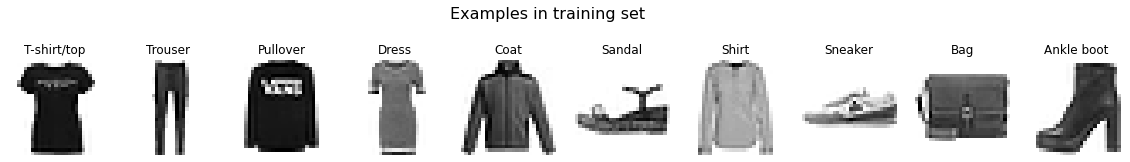

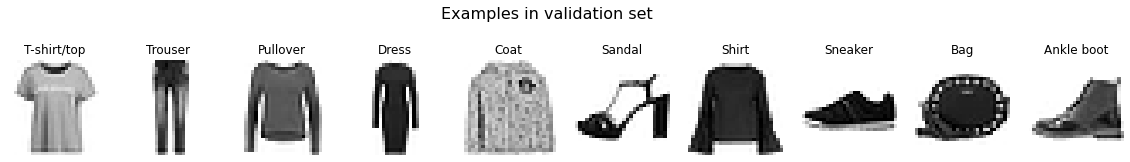

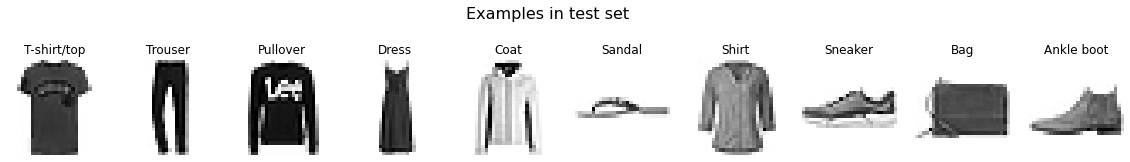

In [6]:
def plot_examples(X, y, title=""):
    """Plot a grid of images from different classes."""
    # Size figure depending on the size of the grid
    plt.figure(figsize=(20, 2))
    plt.suptitle(title, fontsize=16,x=0.5,y=1.2,)

    index = []
    # search index
    for i in range(len(class_names)):
        for j in range(len(y)):
            if i == y[j]:
                index.append(j)
                break

    # Plot the image at appropriate place in grid
    for i in range(len(index)):
        plt.subplot(1, len(index), i + 1)
        plt.imshow(X[index[i]], cmap="binary")
        plt.title(class_names[y[index[i]]])
        plt.axis('off')
            
    plt.show()

print("Some examples:")

plot_examples(X_train, y_train, "Examples in training set")
plot_examples(X_valid, y_valid, "Examples in validation set")
plot_examples(X_test, y_test, "Examples in test set")

## 2. Algorithm design and setup

### 2.1  K-nearest neighbors

First, A group of simple algorithms from the first 6 weeks are compared. They are: K-nearest neighbors, Naive Bayes, Decision tree, and Random forest. We simply train the model with default/simple parameters on the full training set, and test their accuracy.

In [7]:
neigh = KNeighborsClassifier(n_neighbors=10) # k shoule be less than sqrt(#training_examples), commercial packages typically use k=10

# Training and timer
time_stamp = time.time()
neigh.fit(X_train_full.reshape(X_train_full.shape[0], -1), y_train_full)
neigh_training_time = time.time() - time_stamp

In [8]:
nb = GaussianNB()

# Training and timer
time_stamp = time.time()
nb.fit(X_train_full.reshape(X_train_full.shape[0], -1), y_train_full)
nb_training_time = time.time() - time_stamp

In [9]:
# Running in arround 30s

tree = DecisionTreeClassifier(criterion='entropy', random_state=0) # without setting max_depth results in overfitting.

# Training and timer
time_stamp = time.time()
tree.fit(X_train_full.reshape(X_train_full.shape[0], -1), y_train_full)
tree_training_time = time.time() - time_stamp

In [10]:
# Running in arround 90s

rnd = RandomForestClassifier(criterion='entropy', random_state=0) # n_estimators=100 by default

# Training and timer
time_stamp = time.time()
rnd.fit(X_train_full.reshape(X_train_full.shape[0], -1), y_train_full)
rnd_training_time = time.time() - time_stamp

In [11]:
print(f"The accuracy of KNN is {neigh.score(X_test.reshape(X_test.shape[0], -1), y_test):.4f}, training time is {neigh_training_time:.2f} s.")
print(f"The accuracy of NB is {nb.score(X_test.reshape(X_test.shape[0], -1), y_test):.4f}, training time is {nb_training_time:.2f} s.")
print(f"The accuracy of DT is {tree.score(X_test.reshape(X_test.shape[0], -1), y_test):.4f}, training time is {tree_training_time:.2f} s.")
print(f"The accuracy of RF is {rnd.score(X_test.reshape(X_test.shape[0], -1), y_test):.4f}, training time is {rnd_training_time:.2f} s.")

The accuracy of KNN is 0.8519, training time is 0.05 s.
The accuracy of NB is 0.5838, training time is 0.63 s.
The accuracy of DT is 0.8001, training time is 33.76 s.
The accuracy of RF is 0.8760, training time is 86.22 s.


Althouth Random Forest performs best, the training time is relatively long. Noticing that KNN is simple but with a content accuracy among them, the training time is  also tiny. Therefore, KNN is chosen.

### 2.2 Fully connected neural network

First, the numbers of layers need to be settled. Apart from the **input layer** and **output layer**, the numebr of hidden layer can be a variable. According to Cybenko(1998), any function (including discontinuous) can be approximated to arbitrary small error by a network with two hidden layers. To make the model small, we choose **two hidden layers**.

Number of neurons in the input layer: 784   
For numerical attributes, basically 1 neuron per attribute, in this dataset, we have 28 * 28 = 784 atttributes each example. Thus, the number of neurons of input layer should be 784. Simply, we just use **keras.layers.Flatten(input_shape)**

Number of neurons in the output layer: 10   
1 for each class. Therefore, the number of the output layers should be 10. The **softmax** function ($\frac{e^{z_{i}}}{\sum_{j=1}^{K} e^{z_{j}}}$) converts the raw outputs of this layer into a probability distribution over the classes. 

Now we choose the hidden layers.   
**Sigmoid** is the most widely used transfer function.
We simply set most paras by default as well as the basic **SGD** learning algorithm. Since our labels are in index form rather than encoded as one-hot vectors, as we discussed earlier, we utilise the **sparse_categorical_crossentropy** loss. Then we observe the trend of the numbers of neurons with respect to MSE.

In [12]:
def test_build_mlp(num1=50, num2=50):
    """Build the MLP model with the specified number of neurons."""
    # Define a test MLP model
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=IMAGE_SIZE),
        keras.layers.Dense(num1, activation="sigmoid"),
        keras.layers.Dense(num2, activation="sigmoid"),
        keras.layers.Dense(len(class_names), activation="softmax")
    ])

    opt = keras.optimizers.SGD() # default learning_rate=0.01
    model.compile(loss='sparse_categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

    # model.summary()
    return model

def test_train_mlp(num1, num2, max_epochs=50, criterion=0.02):
    """Training the model.
    max_epochs: the maximum number of epochs to terminate.
    criterion: stop when the difference between the loss of the last 5 epoch is less than."""
    # Train the classifier.
    mlp = test_build_mlp(num1, num2)
    loss_list = []
    for i in range(max_epochs):
        history = mlp.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=1)
        loss_list.append(history.history["loss"][0])

        # Stop condition
        if len(loss_list) > 5 and loss_list[-6] - loss_list[-1] < criterion:
            print(len(loss_list))
            break
    
    return loss_list[-1], len(loss_list)

In [13]:
# Running in arround 960s

# some possible numbers to choose
hidden_layer_1 = [100, 200, 300, 400, 500, 600]

# results
loss_history_1 = []
epoch_history_1 = []

# for the first hidden layer
for i in hidden_layer_1:
    loss, epoch = test_train_mlp(i, 50)
    loss_history_1.append(loss)
    epoch_history_1.append(epoch)

1688/1688 [==============================] - 2s 1ms/step - loss: 0.4262 - accuracy: 0.8492 - val_loss: 0.4321 - val_accuracy: 0.8458
31
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4347 - accuracy: 0.8465 - val_loss: 0.4373 - val_accuracy: 0.8442
29
1688/1688 [==============================] - 6s 3ms/step - loss: 0.4303 - accuracy: 0.8479 - val_loss: 0.4332 - val_accuracy: 0.8428
29
1688/1688 [==============================] - 7s 4ms/step - loss: 0.4396 - accuracy: 0.8445 - val_loss: 0.4429 - val_accuracy: 0.8393
29
1688/1688 [==============================] - 7s 4ms/step - loss: 0.4397 - accuracy: 0.8444 - val_loss: 0.4388 - val_accuracy: 0.8402
27
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4388 - accuracy: 0.8455 - val_loss: 0.4414 - val_accuracy: 0.8422
28


In [14]:
loss_history_1 = [round(i, 4) for i in loss_history_1]
print(f"The min loss is {min(loss_history_1)} when neurons is equal to {hidden_layer_1[loss_history_1.index(min(loss_history_1))]}")

print(f"Loss history: {loss_history_1}")
print(f"Epoch history: {epoch_history_1}")

The min loss is 0.4262 when neurons is equal to 100
Loss history: [0.4262, 0.4347, 0.4303, 0.4396, 0.4397, 0.4388]
Epoch history: [31, 29, 29, 29, 27, 28]


It shows that when the number of neurons of the first layer is 100, the loss is minimal. Although the epochs is slightly larger, which may enhance the performance, the training time is much faster because of the lesser neurons. To keep the model small, we choose the 100 as the first number of neurons of the hidden layers.

In [20]:
# Running in arround 340s

# some possible numbers to choose
hidden_layer_2 = [20, 40, 60, 80]

# results
loss_history_2 = []
epoch_history_2 = []

# for the first hidden layer
for i in hidden_layer_2:
    loss, epoch = test_train_mlp(100, i)
    loss_history_2.append(loss)
    epoch_history_2.append(epoch)

1688/1688 [==============================] - 3s 2ms/step - loss: 0.4242 - accuracy: 0.8518 - val_loss: 0.4322 - val_accuracy: 0.8465
33
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4297 - accuracy: 0.8476 - val_loss: 0.4339 - val_accuracy: 0.8418
30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4282 - accuracy: 0.8485 - val_loss: 0.4316 - val_accuracy: 0.8420
30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4258 - accuracy: 0.8500 - val_loss: 0.4300 - val_accuracy: 0.8457
30


In [21]:
loss_history_2 = [round(i, 4) for i in loss_history_2]
print(f"The min loss is {min(loss_history_2)} when neurons is equal to {hidden_layer_2[loss_history_2.index(min(loss_history_2))]}")

print(f"Loss history: {loss_history_2}")
print(f"Epoch history: {epoch_history_2}")

The min loss is 0.4242 when neurons is equal to 20
Loss history: [0.4242, 0.4297, 0.4282, 0.4258]
Epoch history: [33, 30, 30, 30]


We select 20 as the neurons of the second hidden layer using the same method as before consistently. 

### Convolutional neural network

## 3. Hyperparameter tuning

In [82]:
# Helper method in this section.
def get_result(estimator, paras, X_train=X_train, y_train=y_train, X_valid=X_valid, y_valid=y_valid, epochs=1):
    """get grid search result.
    estimator: model to be tuned.
    paras: an instance of ParameterGrid."""
    # Return a dict
    result = {
        "best_paras": None,
        "best_score": 0,
        "best_estimator": None,
        "results": [],
    }

    i = 0

    # Grid search for each combination.
    for para in paras:
        # Set para
        current_estimator = clone(estimator)
        current_estimator.set_params(**para)

        # Training and timer
        t1 = time.time()
        if epochs == 1:
            current_estimator.fit(X_train, y_train)
        else:
            current_estimator.fit(X_train, y_train, epochs=epochs)
        t2 = time.time()

        # Score on validation set
        score = current_estimator.score(X_valid, y_valid)
        t3 = time.time()

        # result for each combination
        temp = {}
        temp["paras"] = para
        temp["training_time"] = t2 - t1
        temp["validation_time"] = t3 - t2
        temp["score"] =score
        
        # Update the best result
        result["results"].append(temp)
        if score > result["best_score"]:
            result["best_paras"] = para
            result["best_score"] = score
            result["best_estimator"] = current_estimator
        
        i += 1
        print(f"{i} out of {len(list(paras))} finished.")

    return result

def show_results(name, result, X_test=X_test, y_test=y_test):
    """Show the results."""
    print(f"Results for {name}:")
    print("Best parameters: {}".format(result["best_paras"]))
    print("Best validation score: {:.4f}".format(result["best_score"]))
    print("Test set score: {:.4f}".format(result["best_estimator"].score(X_test, y_test)))

    # table of results
    df = pd.DataFrame(
        columns=["Score", "training_time", "validation_time"], 
        index=[str(result["results"][i]["paras"]) for i in range(len(result["results"]))]
        )

    for i in range(len(result["results"])):
        df.loc[str(result["results"][i]["paras"])] = [
            round(result["results"][i]["score"], 4),
            round(result["results"][i]["training_time"], 2),
            round(result["results"][i]["validation_time"], 2)
            ]

    df.to_csv(f'{name}_results.csv')
    display(df)

### 3.1 K-nearest neighbors

First, to determine a rough trend of the accuracy with different k, we calculate an accuracy every 10 with different k, until k = 245 (sqrt(#examples)), e.g., k = [1, 11, 21, ..., 241]

In [17]:
# Running in arroung 190s

k_value = [1 + i for i in range(245)]
k_acc = []

for i in k_value:
    if i % 10 != 1:
        continue
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_full.reshape(X_train_full.shape[0], -1), y_train_full)
    k_acc.append(knn.score(X_test.reshape(X_test.shape[0], -1), y_test))
    print(f"k = {i}\t finished.")

k = 1	 finished.
k = 11	 finished.
k = 21	 finished.
k = 31	 finished.
k = 41	 finished.
k = 51	 finished.
k = 61	 finished.
k = 71	 finished.
k = 81	 finished.
k = 91	 finished.


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(2, 2))
fig, ax = plt.subplots()

ax.plot([i*10 + 1 for i in range(25)], k_acc, marker="o")
ax.set(xlabel="k", ylabel="ACC", xticks=range(1, 250, 40))
plt.show()

From the figure, the trend is roughly decending. Therefore, we can choose a range of k in [1, 21]

In [ ]:
# Running in arroung 140s

k_value = [i for i in range(1,21)]
k_acc = []

for i in k_value:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_full.reshape(X_train_full.shape[0], -1), y_train_full)
    k_acc.append(knn.score(X_test.reshape(X_test.shape[0], -1), y_test))
    print(f"k = {i}\t finished.")

In [ ]:
plt.figure(figsize=(2, 2))
fig, ax = plt.subplots()

ax.plot(k_value, k_acc, marker="o")
ax.set(xlabel="k", ylabel="ACC", xticks=k_value)
plt.show()

From the figure above, we chose k = [3, 5, 9]. For p, we chose p [1, 2], it represents manhattan_distance and euclidean_distance respectively. We also consider the weight (uniform, distance) each point contribute to.

If we use CV with 10 folds, totally we need 3 * 2 * 2 * cv = 120 on 90% training set. Considering the running time, we use standard grid search instead.

In [83]:
# Setting parameters
param_grid = {
    'n_neighbors': [3, 5, 9],
    'p': [1, 2],
    "weights": ["uniform", "distance"],
    }

knn_paras = ParameterGrid(param_grid)

print(f"There are {len(list(knn_paras))} combinations.")
print("Parameter grid:\n{}".format(param_grid))

# ----------------------------------------------------------
# CV for tuning
# Setting the 10 fold stratified cross-validation

# cvKFold=StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
# grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=cvKFold, return_train_score=True, verbose=3)
# grid_search.fit(X_train_full.reshape(60000, -1), y_train_full)

There are 6 combinations.
Parameter grid:
{'n_neighbors': [3, 5, 9], 'weights': ['uniform', 'distance']}


In [84]:
# Running in around 410s

# Tuning KNN paras, 12 combination in total.
knn_result = get_result(
    KNeighborsClassifier(), 
    knn_paras, 
    X_train=X_train.reshape(X_train.shape[0], -1), 
    X_valid=X_valid.reshape(X_valid.shape[0], -1)
    )

1 out of 6 finished.
2 out of 6 finished.
3 out of 6 finished.
4 out of 6 finished.
5 out of 6 finished.
6 out of 6 finished.


In [85]:
# Running in around 110s

show_results("KNN", knn_result, X_test=X_test.reshape(X_test.shape[0], -1))

Results for KNN:
Best parameters: {'n_neighbors': 3, 'weights': 'distance'}
Best validation score: 0.8602
Test set score: 0.8530


,Score,training_time,validation_time
"{'n_neighbors': 3, 'weights': 'uniform'}",0.8583,0.08,3.82
"{'n_neighbors': 3, 'weights': 'distance'}",0.8602,0.05,2.89
"{'n_neighbors': 5, 'weights': 'uniform'}",0.855,0.06,3.11
"{'n_neighbors': 5, 'weights': 'distance'}",0.8577,0.05,2.96
"{'n_neighbors': 9, 'weights': 'uniform'}",0.8512,0.06,3.04
"{'n_neighbors': 9, 'weights': 'distance'}",0.8533,0.05,3.03


### 3.2 Fully connected neural network

From section 2.2, we settled the numbers of neurons (100, 20) in hidden layers. Although the number of hidden layers as well as number of neurons are also hyperparameter, to avoid a great running time due to a number of combination of paras, we design the structure first and tune the other paras in this section.

In [86]:
def build_mlp(activation_function="relu"):
    """Build a Keras MLP for 10 class classification with desired parameters."""
    
    model = keras.models.Sequential()
    
    # Add the input layer
    model.add(keras.layers.Flatten(input_shape=IMAGE_SIZE))
    
    # Add the hidden layers with activation function
    model.add(keras.layers.Dense(100, activation=activation_function))
    model.add(keras.layers.Dense(20, activation=activation_function))
        
    # Add the output layer for 10 class classification
    model.add(keras.layers.Dense(10, activation="softmax"))
    
    return model

# Create a KerasClassifier object which works with sklearn grid searches
# We need to pass default values of arguments in build_mlp if we wish to tune them
keras_classifier = KerasClassifier(build_mlp,
                                   activation_function="relu",
                                   loss="sparse_categorical_crossentropy",
                                   optimizer="sgd",
                                   optimizer__lr=0.01,
                                   metrics=["accuracy"]
                                  )

param_grid = {
    "optimizer__lr": [0.1, 0.01, 0.001],
    # "optimizer__lr": [0.1],
    # "activation_function": ["relu", "sigmoid", "tanh", None],
    "activation_function": ["relu"]
}

mpl_paras = ParameterGrid(param_grid)


mlp_result = get_result(keras_classifier, mpl_paras, epochs=2)

Epoch 1/2


c:\Users\1\PycharmProjects\5318\venv\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 3s 1ms/step - loss: 0.5820 - accuracy: 0.7892
Epoch 2/2
188/188 [==============================] - 0s 946us/step
1 out of 3 finished.
Epoch 1/2


c:\Users\1\PycharmProjects\5318\venv\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 0.7850 - accuracy: 0.7347
Epoch 2/2
188/188 [==============================] - 0s 923us/step
2 out of 3 finished.
Epoch 1/2


c:\Users\1\PycharmProjects\5318\venv\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 1.7205 - accuracy: 0.4194
Epoch 2/2
188/188 [==============================] - 0s 923us/step
3 out of 3 finished.


In [87]:
# mlp_result
show_results("MLP", mlp_result)

Results for MLP:
Best parameters: {'activation_function': 'relu', 'optimizer__lr': 0.1}
Best validation score: 0.8018
313/313 [==============================] - 0s 982us/step
Test set score: 0.7899


,Score,training_time,validation_time
"{'activation_function': 'relu', 'optimizer__lr': 0.1}",0.8018,4.88,0.33
"{'activation_function': 'relu', 'optimizer__lr': 0.01}",0.7863,4.63,0.33
"{'activation_function': 'relu', 'optimizer__lr': 0.001}",0.7155,4.67,0.31


### Convolutional neural network

## 4. Final models

### 4.1 K-nearest neighbors

Best paras for K-nearest neighbors is:  
'n_neighbors'= 3, 'p'= 1, 'weights'= 'distance'.

In [ ]:
# Set the best paras
knn_best_paras = dict({'n_neighbors': 3, 'p': 1, 'weights': 'distance'})

knn = KNeighborsClassifier(**knn_best_paras)
knn.fit(X_train_full.reshape(X_train_full.shape[0], -1), y_train_full)

In [ ]:
# Running in around 120s

# Performance on test set.
print(f"KNN score on the test set: {knn.score(X_test.reshape(X_test.shape[0], -1), y_test):.4f}")

### Fully connected neural network

### Convolutional neural network